<a href="https://colab.research.google.com/github/JvitorS23/notebooks-PIBIC/blob/master/kdRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports e seed


In [0]:
!nvidia-smi

Thu Feb 27 00:24:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import os.path
from scipy.io import arff
import pandas as pd
from random import randint
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
import torch
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.nn as nn
import time
import random
from sklearn.metrics import classification_report
from scipy.signal import resample
from sklearn.metrics import confusion_matrix


seed =23
random.seed(seed)

# Download dos dados


In [0]:
!rm -rf /content/heartbeat_dataset

In [0]:
!mkdir heartbeat_dataset
!wget -P  /content/heartbeat_dataset https://www.dropbox.com/s/nxclm1me16kmik7/heartbeat_dataset.zip
!unzip -d /content/heartbeat_dataset /content/heartbeat_dataset/heartbeat_dataset.zip

--2020-02-27 03:56:28--  https://www.dropbox.com/s/nxclm1me16kmik7/heartbeat_dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nxclm1me16kmik7/heartbeat_dataset.zip [following]
--2020-02-27 03:56:28--  https://www.dropbox.com/s/raw/nxclm1me16kmik7/heartbeat_dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5cee1dbf4249c8b10232f553f4.dl.dropboxusercontent.com/cd/0/inline/Ay6vy-KrHWwLaYH44PZAol-q5c9uhpY07tkg8e0CAtVJOeQaHEMgM6ckzf8soZEfPZFow5Inn6qE_--uh_lAGwVuaglwtOi5zPlMZ7ADDkcaCQRlTfyrWrpAn1yq6y6KrWc/file# [following]
--2020-02-27 03:56:29--  https://uc5cee1dbf4249c8b10232f553f4.dl.dropboxusercontent.com/cd/0/inline/Ay6vy-KrHWwLaYH44PZAol-q5c9uhpY07tkg8e0CAtVJOeQaHEMgM6ckzf8soZEfPZFow5Inn6qE_--uh_lAGwV

# Tratamento dos Dados


In [0]:
class ECG_dataset(Dataset):
    def __init__(self,data,labels):
        self.counts = [0,0,0,0,0]
        self.data = data
        self.labels = labels
        for i in range(len(labels)):
          self.counts[labels[int(i)]] = self.counts[labels[int(i)]]+1

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.data[idx], self.labels[idx]

def ecg_data():
  #read the data
  df = pd.read_csv("heartbeat_dataset/mitbih_train.csv", header=None)

  # define data samples
  X_short = df.iloc[0:,0:187].values

  # define target
  y_short = df.iloc[0:,187].values.astype(int)

  time_steps = 1

  # use stratshufflesplit to get indices for test and training data
  sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=10)
  sss.get_n_splits(X_short, y_short)

  # take the indices generated by stratified shuffle split and make the test and training datasets
  for train_index, valid_index in sss.split(X_short, y_short):
    X_train, X_val = X_short[train_index], X_short[valid_index]
    y_train, y_val = y_short[train_index], y_short[valid_index]

  X_train = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
  X_val = X_val.reshape(X_val.shape[0], time_steps, X_val.shape[1])


  #test dataset
  test  = pd.read_csv("heartbeat_dataset/mitbih_test.csv", header=None)
  # define data samples
  X_test = test.iloc[0:,0:187].values

  # define target
  y_test = test.iloc[0:,187].values.astype(int)
  X_test = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])


  train_data = torch.from_numpy(X_train).type(torch.Tensor)
  test_data = torch.from_numpy(X_test).type(torch.Tensor)
  valid_data = torch.from_numpy(X_val).type(torch.Tensor)
  train_labels = torch.from_numpy(y_train).type(torch.LongTensor)
  test_labels = torch.from_numpy(y_test).type(torch.LongTensor)
  valid_labels = torch.from_numpy(y_val).type(torch.LongTensor)

  #Cria o Dataset a partir dos dados
  train_set = ECG_dataset(train_data, train_labels)
  valid_set = ECG_dataset(valid_data, valid_labels)
  test_set = ECG_dataset(test_data, test_labels)

  #Cria o batch loader
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)
  valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=32)
  return train_loader, valid_loader, test_loader

def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def jitter(X, sigma=0.01):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

def balancearDataset():

# essa função divide os dados por categoria e acrescenta amostrar nas categorias com menos de 20000 amostras
# essa adição de amostras é feita usando data augmentation, aplicando amplificação e encolhimento na série temporal
  train = pd.read_csv("heartbeat_dataset/mitbih_train.csv", header=None)

  X = train.iloc[0:,0:187].values

  # standardize data
  min_max_scaler = preprocessing.MinMaxScaler()
  X = min_max_scaler.fit_transform(X)

  # define target
  y = train.iloc[0:,187].values.astype(int)

  #encontra os indices de cada classe
  C0_idx = np.argwhere(y == 0).flatten()
  C1_idx = np.argwhere(y == 1).flatten()
  C2_idx = np.argwhere(y == 2).flatten()
  C3_idx  = np.argwhere(y == 3).flatten()
  C4_idx  = np.argwhere(y == 4).flatten()

  #serapa as amostras por classe
  C0 = X[C0_idx[0:20000]]
  C1 = X[C1_idx]
  C2 = X[C2_idx]
  C3 = X[C3_idx]
  C4 = X[C4_idx]

  # cria novas amostras pra cada categoria usando data augmentation
  while len(C1)<20000:
    idx = randint(0, len(C1)-1)
    aug = randint(0,2)
    if aug == 0:
      C1 = np.append(C1, [amplify(C1[idx])],axis=0)
    elif aug==1:
      C1 = np.append(C1, [stretch(C1[idx])],axis=0)
    elif aug==2:
      C1 = np.append(C1, [jitter(C1[idx])],axis=0)

  while len(C2)<20000:
    idx = randint(0, len(C2)-1)
    aug = randint(0,2)
    if aug == 0:
      C2 = np.append(C2, [amplify(C2[idx])],axis=0)
    elif aug==1:
      C2 = np.append(C2, [stretch(C2[idx])],axis=0)
    elif aug==2:
      C2 = np.append(C2, [jitter(C2[idx])],axis=0)

  while len(C3)<20000:
    idx = randint(0, len(C3)-1)
    aug = randint(0,2)
    if aug == 0:
      C3 = np.append(C3, [amplify(C3[idx])],axis=0)
    elif  aug==1:
       C3 = np.append(C3, [stretch(C3[idx])],axis=0)
    elif aug==2:
      C3 = np.append(C3, [jitter(C3[idx])],axis=0)

  while len(C4)<20000:
    idx = randint(0, len(C4)-1)
    aug = randint(0,2)
    if aug == 0:
      C4 = np.append(C4, [amplify(C4[idx])],axis=0)
    elif aug==1:
      C4 = np.append(C4, [stretch(C4[idx])],axis=0)
    elif aug==2:
      C4 = np.append(C4, [jitter(C4[idx])],axis=0)

  # concatena as categorias
  data = np.append(C0,C1, axis=0)
  data = np.append(data, C2, axis=0)
  data = np.append(data, C3, axis=0)
  data = np.append(data, C4, axis=0)

  #cria as labels
  labels = np.append(np.zeros(len(C0)), np.ones(len(C1)),axis=0)
  labels = np.append(labels, np.ones(len(C2))*2, axis=0)
  labels = np.append(labels, np.ones(len(C3))*3, axis=0)
  labels = np.append(labels, np.ones(len(C4))*4, axis=0)

  sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=seed)
  sss.get_n_splits(data, labels)

  for train_index, val_index in sss.split(data, labels):
    X_train, X_val = data[train_index], data[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

  #test dataset
  test  = pd.read_csv("heartbeat_dataset/mitbih_test.csv", header=None)

  # define data samples
  X_test = test.iloc[0:,0:187].values

  time_steps = 1

  # define target
  y_test = test.iloc[0:,187].values.astype(int)
  X_test = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])
  y_test = y_test.reshape(y_test.shape[0], time_steps)

  X_train = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
  y_train = y_train.reshape(y_train.shape[0], time_steps)
  X_val = X_val.reshape(X_val.shape[0], time_steps, X_val.shape[1])
  y_val = y_val.reshape(y_val.shape[0], time_steps)



  return X_train, y_train, X_val, y_val, X_test, y_test

def getLoaders():
  X_train, y_train, X_val, y_val, X_test, y_test = balancearDataset()

  #transformar em tensores
  train_data   = torch.from_numpy(X_train).type(torch.Tensor)
  valid_data   = torch.from_numpy(X_val).type(torch.Tensor)
  test_data    = torch.from_numpy(X_test).type(torch.Tensor)

  train_labels = torch.from_numpy(y_train).type(torch.LongTensor).view(-1)
  valid_labels = torch.from_numpy(y_val).type(torch.LongTensor).view(-1)
  test_labels  = torch.from_numpy(y_test).type(torch.LongTensor).view(-1)

  #Cria o Dataset a partir dos dados
  train_set = ECG_dataset(train_data, train_labels)
  valid_set = ECG_dataset(valid_data, valid_labels)
  test_set  = ECG_dataset(test_data, test_labels)

  #Cria o batch loader
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=False, num_workers=0)
  valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False, num_workers=0)
  test_loader  = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=0)

  return train_loader, valid_loader, test_loader

In [0]:
train_loader, valid_loader, test_loader = ecg_data()
batch = next(iter(train_loader))
data, target = batch

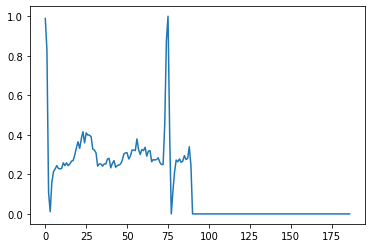

In [0]:
plt.plot(data[0][0])
plt.show()

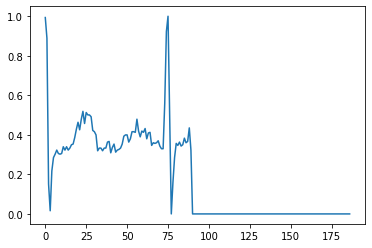

In [0]:
plt.plot(amplify(data[0][0]))
plt.show()

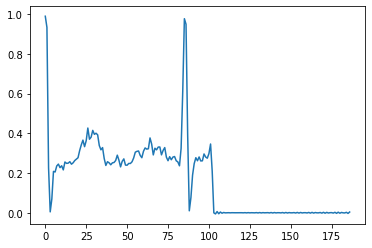

In [0]:
plt.plot(stretch(data[0][0]))
plt.show()

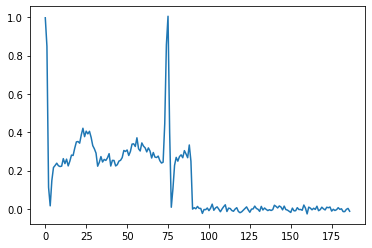

In [0]:
plt.plot(jitter(data[0][0]))
plt.show()

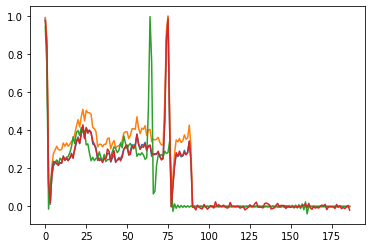

In [0]:
plt.plot(data[0][0])
plt.plot(amplify(data[0][0]))
plt.plot(stretch(data[0][0]))
plt.plot(jitter(data[0][0]))
plt.show()

# Modelos



In [0]:
class ModeloLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, batch):
    super().__init__()
    self.bs = batch
    self.numLayers = 1
    self.hidden_size = hidden_size
    #LSTM layer, batch_first para usar batchs
    self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=self.numLayers, batch_first=True)#num_layers é a quantidade de celulas LSTM agrupadas
    self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers=self.numLayers, batch_first=True)#num_layers é a quantidade de celulas LSTM agrupadas
    self.lstm3 = nn.LSTM(hidden_size, hidden_size, num_layers=self.numLayers, batch_first=True)#num_layers é a quantidade de celulas LSTM agrupadas
    self.linear = nn.Linear(hidden_size, 5)
    self.drop = nn.Dropout(p=0.5)
  
  def forward(self, input):
    h0 = c0 = torch.zeros(self.numLayers,input.shape[0],self.hidden_size)
    if torch.cuda.is_available():
        h0 = h0.cuda()
        c0 = c0.cuda()    
    lstm1_out, (h0,c0) = self.lstm1(input, (h0,c0))    
    lstm2_out, (h0,c0) = self.lstm2(lstm1_out, (h0,c0))
    drop1 = self.drop(lstm2_out)
    lstm3_out, (h0,c0) = self.lstm3(drop1, (h0,c0))    
    drop2 = self.drop(lstm3_out)
    predictions = self.linear(drop2.view(len(input), -1))
    return predictions

class ModeloRNN(nn.Module):
  def __init__(self, input_size, hidden_size, batch):
    super().__init__()
    self.bs = batch
    self.numLayers = 1
    self.hidden_size = hidden_size
    self.rnn1 = nn.RNN(input_size, hidden_size, num_layers=self.numLayers, batch_first=True)
    self.rnn2 = nn.RNN(hidden_size, hidden_size, num_layers=self.numLayers, batch_first=True)
    self.rnn3 = nn.RNN(hidden_size, hidden_size, num_layers=self.numLayers, batch_first=True)
    self.linear = nn.Linear(hidden_size, 5)

    self.drop = nn.Dropout(p=0.5)

  def forward(self, input):
    h0 = torch.zeros(self.numLayers,input.shape[0],self.hidden_size)
    if torch.cuda.is_available():
        h0 = h0.cuda()
    rnn1_out, h0 = self.rnn1(input, h0)
    rnn2_out, h0 = self.rnn2(rnn1_out, h0)
    drop1 = self.drop(rnn2_out)
    rnn3_out, h0 = self.rnn3(drop1, h0)
    drop2 = self.drop(rnn3_out)
    predictions = self.linear(drop2.view(len(input), -1))
    return predictions

# Funções 



In [0]:

def plotar(train_loss, train_acc, val_loss, val_acc):
  plt.title('Accuracy over epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(train_acc, label='train')
  plt.plot(val_acc, label='val')
  plt.grid(True, which='both', axis='both')
  plt.tight_layout()
  plt.legend()
  plt.show()
  plt.title('Loss over epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(train_loss, label='train')
  plt.plot(val_loss, label='val')
  plt.grid(True, which='both', axis='both')
  plt.tight_layout()
  plt.legend()
  plt.show()

def carregar_modeloLSTM(model_save_name):
  model = ModeloLSTM(187, 30, 32)
  model.load_state_dict(torch.load(model_save_name))
  return model

def carregar_modeloRNN(model_save_name):
  model = ModeloRNN(187, 30, 32)
  model.load_state_dict(torch.load(model_save_name))
  return model

def salvar_modelo(model, model_save_name):
  torch.save(model.state_dict(), model_save_name)

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
              print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'bestLoss.model')
        self.val_loss_min = val_loss

def treinamento(train_loader, valid_loader, model, num_epochs, verbose):
  train_losses , train_accuracy = [],[]
  val_losses , val_accuracy = [],[]

  optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # sets optimizer
  scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=20, verbose=verbose, min_lr=0.00005)
  best_loss, best_acc = fit(verbose, optimizer, scheduler,model,valid_loader, phase='validation')

  if verbose:
    print("best_acc: " + str(best_acc))

  # initialize the early_stopping object
  early_stopping = EarlyStopping(patience=30, verbose=verbose)

  for epoch in range(1,num_epochs+1):
    if verbose:
      print('epoch {}/{}'.format(epoch, num_epochs))
      print('=' * 10)
    epochStart = time.time()
    train_epoch_loss, train_epoch_accuracy = fit(verbose, optimizer, scheduler, model, train_loader, phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(verbose, optimizer, scheduler, model, valid_loader, phase='validation')
    epochEnd = time.time()

    if verbose:
      print('Duração:', (epochEnd - epochStart))

    if val_epoch_accuracy >= best_acc:
      best_acc = val_epoch_accuracy
      best_loss = val_epoch_loss
      salvar_modelo(model, 'bestAccuracy.model')

    train_losses.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    early_stopping(val_epoch_loss, model)

    if early_stopping.early_stop:
      print("Early stopping in epoch", epoch)
      break

  return train_losses, train_accuracy, val_losses, val_accuracy

def fit(verbose, optimizer, scheduler, model, data_loader, phase='training'):
  if phase == 'training':
    model.train()
  if phase == 'validation':
    model.eval()
  running_loss = 0.0
  running_correct = 0

  for batch in data_loader:
    data , target = batch
    if torch.cuda.is_available():
      data,target = data.cuda(),target.cuda()

    if phase == 'training':
      optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(output,target)
    running_loss += loss.item()
    running_correct += output.argmax(dim=1).eq(target).sum().item()
    if phase == 'training':
      loss.backward()
      optimizer.step()
  loss = running_loss/len(data_loader.dataset)
  accuracy = 100. * running_correct/len(data_loader.dataset)
  if phase == 'validation':
    scheduler.step(accuracy)
  if verbose:
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{6}.{4}}%')
  return loss,accuracy

def infoModelo(model):
  print(model)
  pytorch_total_params = sum(p.numel() for p in model.parameters())
  pytorch_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print('Total params: ', pytorch_total_params)
  print('Trainable params: ', pytorch_trainable_params)

def testeDoModelo(model, data_loader):
  if (torch.cuda.is_available()):
    model = model.cuda()
  model.eval()
  running_loss = 0.0
  running_correct = 0
  tot_predictions = []
  labels = []
  for batch in data_loader:
    data , target = batch
    if torch.cuda.is_available():
      data,target = data.cuda(),target.cuda()
    output = model(data)
    loss = F.cross_entropy(output,target)
    running_loss += loss.item()
    preds = output.data.max(dim=1,keepdim=True)[1]
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum().item()
    tot_predictions.extend(preds.data.cpu().numpy())
    labels.extend(target.data.cpu().numpy())
  loss = running_loss/len(data_loader.dataset)
  accuracy = 100. * running_correct/len(data_loader.dataset)
  print(f'Loss is {loss:{5}.{2}} Accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{6}.{4}}%\n')
  return tot_predictions, labels

def logitsDoModelo(model, data_loader):
  if (torch.cuda.is_available()):
    model = model.cuda()
  model.eval()
  running_loss = 0.0
  running_correct = 0
  corrects = 0
  logits = []
  for batch in data_loader:
    data , target = batch
    if torch.cuda.is_available():
      data,target = data.cuda(),target.cuda()
    output = model(data)
    loss = F.cross_entropy(output,target)
    running_loss += loss.item()
    preds = output.data.max(dim=1,keepdim=True)[1]
    logits.extend(output.data.cpu().numpy())
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum().item()
  loss = running_loss/len(data_loader.sampler)
  accuracy = 100. * running_correct/len(data_loader.sampler)
  print(f'Test loss is {loss:{5}.{2}} and Test accuracy is {running_correct}/{len(data_loader.sampler)}{accuracy:{6}.{4}}%\n')
  return logits

def getLogitsDoModelo(train_loader, valid_loader, test_loader):

  modelBL = carregar_modeloLSTM('bestLoss.model')
  train_logits = logitsDoModelo(modelBL, train_loader)
  train_logits = torch.tensor(train_logits)
  train_logits = train_logits.cuda()

  valid_logits = logitsDoModelo(modelBL, valid_loader)
  valid_logits = torch.tensor(valid_logits)
  valid_logits = valid_logits.cuda()

  test_logits = logitsDoModelo(modelBL, test_loader)
  test_logits = torch.tensor(test_logits)
  test_logits = test_logits.cuda()

  return train_logits, valid_logits, test_logits

def metricasModelo(model, data_loader):
  if (torch.cuda.is_available()):
    model = model.cuda()
  print('========= Métricas do modelo ============\n')
  y_pred, y_test = testeDoModelo(model, data_loader)
  target_names = ['N', 'S', 'V', 'F', 'Q']
  print(classification_report(y_test, y_pred, target_names=target_names, digits=3))
  print('\n========= Confusion Matrix ============\n')
  confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[0,1,2,3,4])
  fig, ax = plt.subplots(figsize=(7,7))
  ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(confmat.shape[0]):
      for j in range(confmat.shape[1]):
          ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
  plt.xlabel('predicted label')
  plt.ylabel('true label')
  plt.tight_layout()
  plt.savefig('confusion_matrix.png', dpi=300)
  plt.show()


# Treinamento LSTM dataset desbalanceado


In [0]:
#Download e preparação dos dados
train_loader, valid_loader, test_loader = ecg_data()
#verificação CUDA
print('CUDA', torch.cuda.is_available())
#Cria o modelo 
model = ModeloLSTM(187, 20, 32)
if(torch.cuda.is_available):
  model = model.cuda()

infoModelo(model)

CUDA True
ModeloLSTM(
  (lstm1): LSTM(187, 20, batch_first=True)
  (lstm2): LSTM(20, 20, batch_first=True)
  (lstm3): LSTM(20, 20, batch_first=True)
  (linear): Linear(in_features=20, out_features=5, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)
Total params:  23545
Trainable params:  23545


In [0]:
train_losses, train_accuracy, val_losses, val_accuracy  = treinamento(train_loader, valid_loader, model, 50, True)

validation loss is 0.047 and validation accuracy is 1896/17511 10.83%
best_acc: 10.827479869796129
epoch 1/50
training loss is 0.014 and training accuracy is 62265/70043  88.9%
validation loss is 0.0079 and validation accuracy is 16304/17511 93.11%
Duração: 11.352455615997314
Validation loss decreased (inf --> 0.007866).  Saving model ...
epoch 2/50
training loss is 0.008 and training accuracy is 65473/70043 93.48%
validation loss is 0.0062 and validation accuracy is 16583/17511  94.7%
Duração: 10.897183179855347
Validation loss decreased (0.007866 --> 0.006242).  Saving model ...
epoch 3/50
training loss is 0.0068 and training accuracy is 66220/70043 94.54%
validation loss is 0.0056 and validation accuracy is 16665/17511 95.17%
Duração: 10.899704694747925
Validation loss decreased (0.006242 --> 0.005598).  Saving model ...
epoch 4/50
training loss is 0.006 and training accuracy is 66679/70043  95.2%
validation loss is 0.0051 and validation accuracy is 16772/17511 95.78%
Duração: 11.08

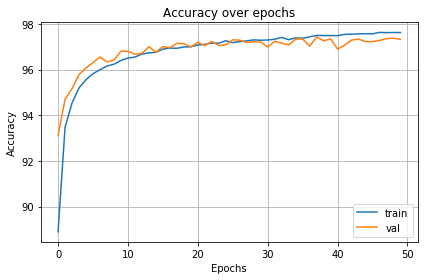

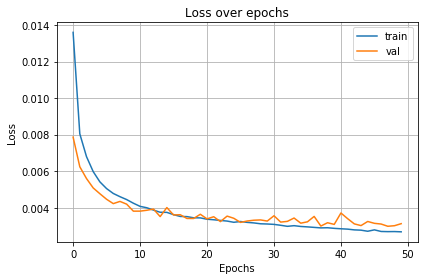

In [0]:
plotar(train_losses, train_accuracy, val_losses, val_accuracy)

Métricas e matriz de confusão usando dataset desbalanceado

Train set
========= Métricas do modelo ============

Loss is 0.0022 Accuracy is 68627/70043 97.98%

              precision    recall  f1-score   support

           N      0.981     0.997     0.989     57977
           S      0.957     0.665     0.785      1778
           V      0.965     0.920     0.942      4630
           F      0.922     0.624     0.744       513
           Q      0.986     0.979     0.982      5145

    accuracy                          0.980     70043
   macro avg      0.962     0.837     0.889     70043
weighted avg      0.979     0.980     0.979     70043


========= Confusion Matrix ============



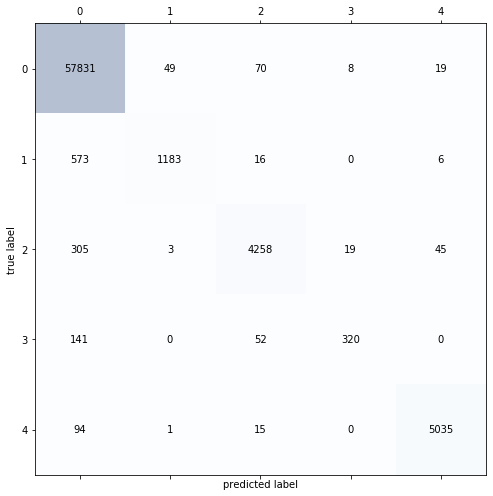

Valid set
========= Métricas do modelo ============

Loss is 0.003 Accuracy is 17048/17511 97.36%

              precision    recall  f1-score   support

           N      0.978     0.995     0.986     14494
           S      0.898     0.616     0.731       445
           V      0.939     0.892     0.915      1158
           F      0.873     0.539     0.667       128
           Q      0.979     0.977     0.978      1286

    accuracy                          0.974     17511
   macro avg      0.934     0.804     0.855     17511
weighted avg      0.973     0.974     0.972     17511


========= Confusion Matrix ============



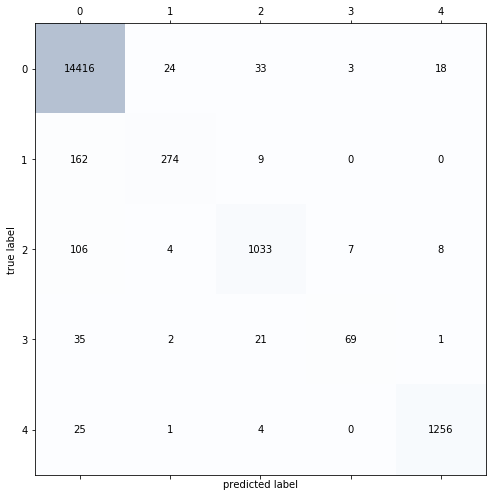

Test set
========= Métricas do modelo ============

Loss is 0.0032 Accuracy is 21269/21892 97.15%

              precision    recall  f1-score   support

           N      0.976     0.994     0.985     18118
           S      0.887     0.592     0.710       556
           V      0.942     0.885     0.912      1448
           F      0.832     0.580     0.684       162
           Q      0.980     0.967     0.973      1608

    accuracy                          0.972     21892
   macro avg      0.923     0.804     0.853     21892
weighted avg      0.970     0.972     0.970     21892


========= Confusion Matrix ============



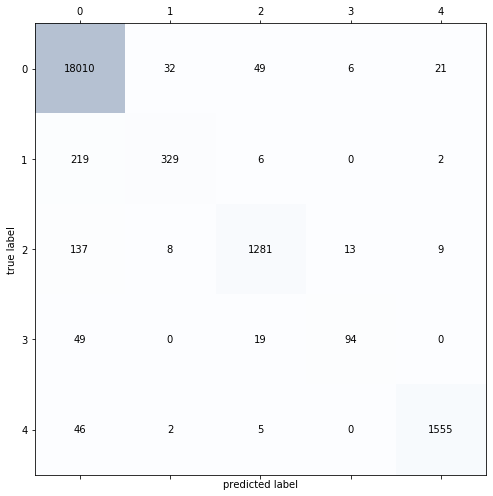

In [0]:
  train_loader, valid_loader, test_loader = ecg_data()

  #Cria o modelo
  model = carregar_modeloLSTM('bestLoss.model')
  print('Train set')
  metricasModelo(model, train_loader)
  print('Valid set')
  metricasModelo(model, valid_loader)
  print('Test set')
  metricasModelo(model, test_loader)

# Treinamento LSTM usando dataset balanceado


In [0]:
#verificação CUDA
print('CUDA', torch.cuda.is_available())

#Cria o modelo 
model = ModeloLSTM(187, 30, 32)

if(torch.cuda.is_available):
  model = model.cuda()

infoModelo(model)


CUDA True
ModeloLSTM(
  (lstm1): LSTM(187, 30, batch_first=True)
  (lstm2): LSTM(30, 30, batch_first=True)
  (lstm3): LSTM(30, 30, batch_first=True)
  (linear): Linear(in_features=30, out_features=5, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)
Total params:  41315
Trainable params:  41315


In [0]:
train_loader, valid_loader, test_loader = getLoaders()


In [0]:
train_losses, train_accuracy, val_losses, val_accuracy  = treinamento(train_loader, valid_loader, model, 100, True)


validation loss is 0.051 and validation accuracy is 4000/20000  20.0%
best_acc: 20.0
epoch 1/100
training loss is 0.022 and training accuracy is 59312/80000 74.14%
validation loss is 0.015 and validation accuracy is 16568/20000 82.84%
Duração: 12.5577712059021
Validation loss decreased (inf --> 0.014966).  Saving model ...
epoch 2/100
training loss is 0.015 and training accuracy is 66682/80000 83.35%
validation loss is 0.012 and validation accuracy is 17151/20000 85.75%
Duração: 12.396455764770508
Validation loss decreased (0.014966 --> 0.012366).  Saving model ...
epoch 3/100
training loss is 0.013 and training accuracy is 68922/80000 86.15%
validation loss is  0.01 and validation accuracy is 17657/20000 88.28%
Duração: 12.087171792984009
Validation loss decreased (0.012366 --> 0.010394).  Saving model ...
epoch 4/100
training loss is 0.011 and training accuracy is 70331/80000 87.91%
validation loss is 0.0091 and validation accuracy is 17909/20000 89.55%
Duração: 12.51293659210205
Val

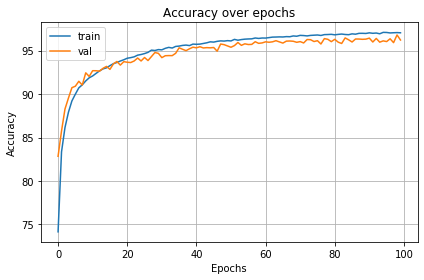

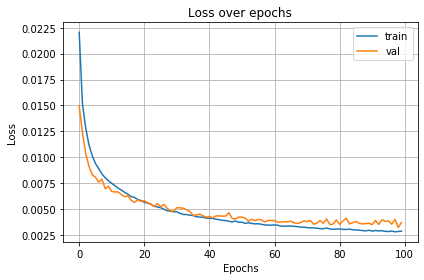

In [0]:
plotar(train_losses, train_accuracy, val_losses, val_accuracy)

Train set
========= Métricas do modelo ============

Loss is 0.0019 Accuracy is 78400/80000  98.0%

              precision    recall  f1-score   support

           N      0.969     0.971     0.970     16000
           S      0.977     0.978     0.977     16000
           V      0.980     0.976     0.978     16000
           F      0.982     0.980     0.981     16000
           Q      0.992     0.995     0.994     16000

    accuracy                          0.980     80000
   macro avg      0.980     0.980     0.980     80000
weighted avg      0.980     0.980     0.980     80000


========= Confusion Matrix ============



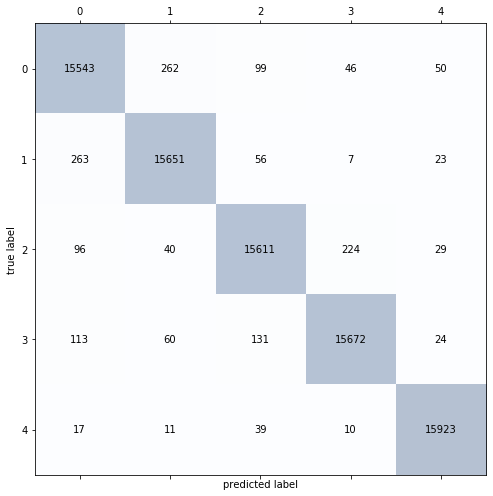

Valid set
========= Métricas do modelo ============

Loss is 0.0032 Accuracy is 19362/20000 96.81%

              precision    recall  f1-score   support

           N      0.950     0.954     0.952      4000
           S      0.957     0.959     0.958      4000
           V      0.972     0.965     0.968      4000
           F      0.974     0.974     0.974      4000
           Q      0.988     0.989     0.988      4000

    accuracy                          0.968     20000
   macro avg      0.968     0.968     0.968     20000
weighted avg      0.968     0.968     0.968     20000


========= Confusion Matrix ============



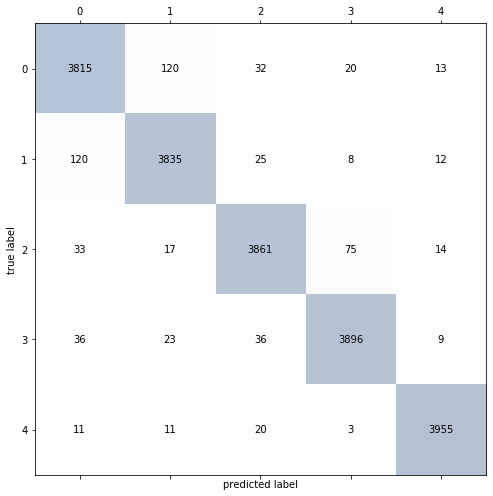

Test set
========= Métricas do modelo ============

Loss is 0.0057 Accuracy is 20685/21892 94.49%

              precision    recall  f1-score   support

           N      0.993     0.945     0.969     18118
           S      0.431     0.845     0.571       556
           V      0.844     0.943     0.891      1448
           F      0.553     0.870     0.676       162
           Q      0.939     0.984     0.961      1608

    accuracy                          0.945     21892
   macro avg      0.752     0.918     0.814     21892
weighted avg      0.962     0.945     0.951     21892


========= Confusion Matrix ============



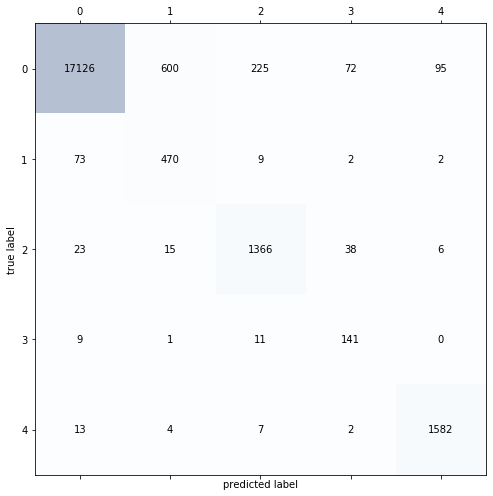

In [0]:
  model = carregar_modeloLSTM('bestLoss.model')
  print('Train set')
  metricasModelo(model, train_loader)
  print('Valid set')
  metricasModelo(model, valid_loader)
  print('Test set')
  metricasModelo(model, test_loader)

# logits do modelo LSTM


In [0]:
train_logits, valid_logits, test_logits = getLogitsDoModelo(train_loader, valid_loader, test_loader)

Test loss is 0.0019 and Test accuracy is 78400/80000  98.0%

Test loss is 0.0032 and Test accuracy is 19362/20000 96.81%

Test loss is 0.0057 and Test accuracy is 20685/21892 94.49%



# Treinamento convencional modelo RNN dataset balanceado

In [0]:
train_loader, valid_loader, test_loader = getLoaders()

80000 20000


In [0]:
#verificação CUDA
print('CUDA', torch.cuda.is_available())

#Cria o modelo 
model2 = ModeloRNN(187, 30, 32)

if(torch.cuda.is_available):
  model2 = model2.cuda()

infoModelo(model2)

CUDA True
ModeloRNN(
  (rnn1): RNN(187, 30, batch_first=True)
  (rnn2): RNN(30, 30, batch_first=True)
  (rnn3): RNN(30, 30, batch_first=True)
  (linear): Linear(in_features=30, out_features=5, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)
Total params:  10445
Trainable params:  10445


In [0]:
train_losses, train_accuracy, val_losses, val_accuracy  = treinamento(train_loader, valid_loader, model2, 100, True)

validation loss is  0.05 and validation accuracy is 4132/20000 20.66%
best_acc: 20.66
epoch 1/100
training loss is 0.025 and training accuracy is 56392/80000 70.49%
validation loss is 0.017 and validation accuracy is 15977/20000 79.89%
Duração: 12.005348205566406
Validation loss decreased (inf --> 0.017217).  Saving model ...
epoch 2/100
training loss is 0.017 and training accuracy is 64280/80000 80.35%
validation loss is 0.014 and validation accuracy is 16942/20000 84.71%
Duração: 11.744853973388672
Validation loss decreased (0.017217 --> 0.013531).  Saving model ...
epoch 3/100
training loss is 0.015 and training accuracy is 67257/80000 84.07%
validation loss is 0.012 and validation accuracy is 17372/20000 86.86%
Duração: 12.013234615325928
Validation loss decreased (0.013531 --> 0.011623).  Saving model ...
epoch 4/100
training loss is 0.013 and training accuracy is 68845/80000 86.06%
validation loss is 0.012 and validation accuracy is 17382/20000 86.91%
Duração: 11.85513424873352
V

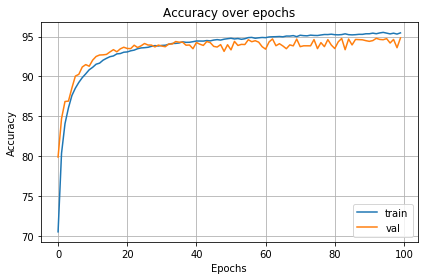

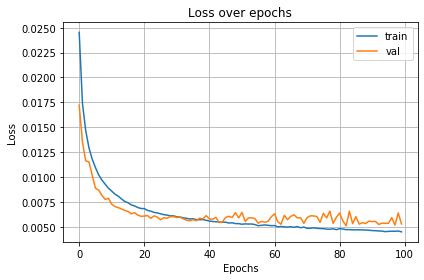

In [0]:
plotar(train_losses, train_accuracy, val_losses, val_accuracy)

Train set
========= Métricas do modelo ============

Loss is 0.0037 Accuracy is 76815/80000 96.02%

              precision    recall  f1-score   support

           N      0.921     0.964     0.942     16000
           S      0.967     0.940     0.953     16000
           V      0.961     0.951     0.956     16000
           F      0.973     0.960     0.966     16000
           Q      0.981     0.985     0.983     16000

    accuracy                          0.960     80000
   macro avg      0.961     0.960     0.960     80000
weighted avg      0.961     0.960     0.960     80000


========= Confusion Matrix ============



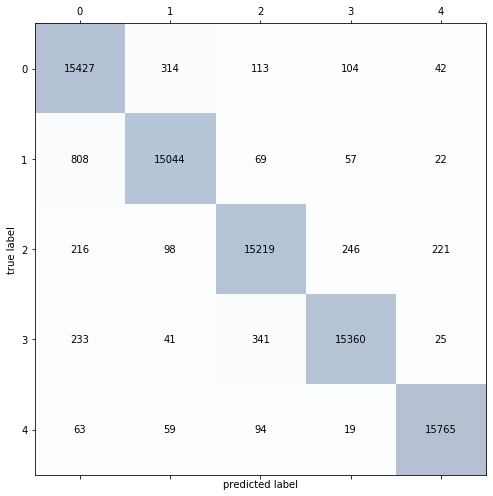

Valid set
========= Métricas do modelo ============

Loss is 0.0051 Accuracy is 18956/20000 94.78%

              precision    recall  f1-score   support

           N      0.902     0.949     0.925      4000
           S      0.950     0.922     0.936      4000
           V      0.950     0.940     0.945      4000
           F      0.960     0.950     0.955      4000
           Q      0.980     0.978     0.979      4000

    accuracy                          0.948     20000
   macro avg      0.948     0.948     0.948     20000
weighted avg      0.948     0.948     0.948     20000


========= Confusion Matrix ============



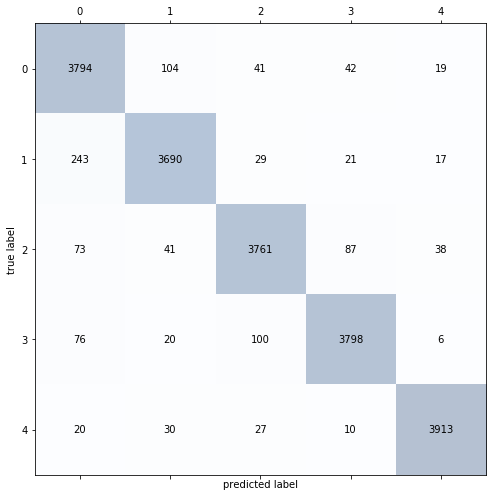

Test set
========= Métricas do modelo ============

Loss is 0.0065 Accuracy is 20583/21892 94.02%

              precision    recall  f1-score   support

           N      0.992     0.943     0.967     18118
           S      0.436     0.808     0.566       556
           V      0.825     0.932     0.875      1448
           F      0.408     0.852     0.552       162
           Q      0.941     0.970     0.956      1608

    accuracy                          0.940     21892
   macro avg      0.720     0.901     0.783     21892
weighted avg      0.958     0.940     0.947     21892


========= Confusion Matrix ============



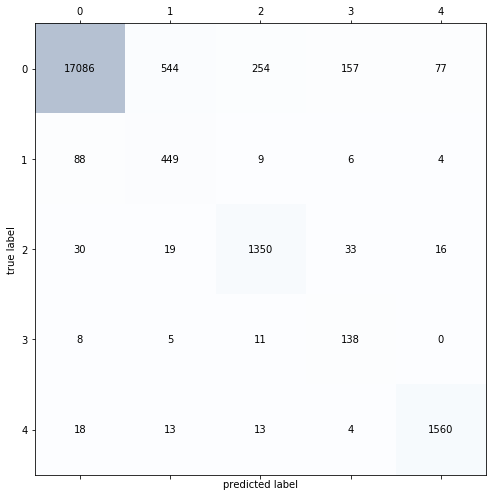

In [0]:
  model = carregar_modeloRNN('bestLoss.model')
  print('Train set')
  metricasModelo(model, train_loader)
  print('Valid set')
  metricasModelo(model, valid_loader)
  print('Test set')
  metricasModelo(model, test_loader)

# Função Treinamento KD


In [0]:
def treinamentoSoft(train_logits, valid_logits, train_loader, valid_loader, model, num_epochs, verbose):
  train_losses , train_accuracy = [],[]
  val_losses , val_accuracy = [],[]
  totalTime = 0
  optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # sets optimizer
  scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=20, verbose=verbose, min_lr=0.00005)
  best_loss, best_acc = fitSoft(valid_logits, verbose, optimizer, scheduler,model,valid_loader, phase='validation')
  
  if verbose:
    print("best_acc: " + str(best_acc))

  # initialize the early_stopping object
  early_stopping = EarlyStopping(patience=30, verbose=verbose)

  for epoch in range(1,num_epochs+1):
    if verbose:   
      print('epoch {}/{}'.format(epoch, num_epochs))
      print('=' * 10)
    epochStart = time.time()
    train_epoch_loss, train_epoch_accuracy = fitSoft(train_logits, verbose, optimizer, scheduler, model, train_loader, phase='training')
    val_epoch_loss , val_epoch_accuracy = fitSoft(valid_logits, verbose, optimizer, scheduler, model, valid_loader, phase='validation')
    epochEnd = time.time() 

    if verbose:   
      print('Duração:', (epochEnd - epochStart))

    if val_epoch_accuracy >= best_acc:
      best_acc = val_epoch_accuracy
      best_loss = val_epoch_loss
      salvar_modelo(model, 'bestAccuracy.model')
    
    train_losses.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
   
    early_stopping(val_epoch_loss, model)
    if early_stopping.early_stop:
      print("Early stopping in epoch", epoch)
      break
  
  return train_losses, train_accuracy, val_losses, val_accuracy 

def fitSoft(teacher_target, verbose, optimizer, scheduler, model, data_loader, phase='training'):
  if phase == 'training':
    model.train()
  if phase == 'validation':
    model.eval()
  running_loss = 0.0
  running_correct = 0
  ini = 0
  fim = 0
  for batch in data_loader:
    data , target = batch        
    fim = fim + len(target)
    if torch.cuda.is_available():
      data,target = data.cuda(),target.cuda()
    if phase == 'training':
      optimizer.zero_grad()
    output = model(data)
    soft_target = teacher_target[ini:fim]
    loss = loss_fn_kd(output, target, soft_target, 5)
    running_loss += loss.item()
    output = output.data.cpu().numpy()   
    preds = np.argmax(output, axis=1)     
    running_correct += getCorrects(preds, target)
    if phase == 'training':
      loss.backward()
      optimizer.step()   
    ini = ini + len(target) 
  loss = running_loss/len(data_loader.sampler)
  accuracy = 100. * running_correct/len(data_loader.sampler)
  if phase == 'validation':
    scheduler.step(accuracy)
  if verbose:
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.sampler)}{accuracy:{6}.{4}}%')
  return loss,accuracy


def loss_fn_kd(outputs, labels, teacher_outputs, temperature): 
  """ 
  Compute the knowledge-distillation (KD) loss given outputs, labels. 
  "Hyperparameters": temperature and alpha 

  NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher 
  and student expects the input tensor to be log probabilities! See Issue #2 
  """ 
  alpha = 0.6
  T = temperature 
  KD_loss = nn.KLDivLoss()(F.softmax(outputs/T, dim=1), 
                          F.softmax(teacher_outputs/T, dim=1))*T*T*alpha + F.cross_entropy(outputs, labels) * (1. - alpha) 

  return KD_loss 

def getCorrects(preds, targets):  
  corretos = 0
  for i in range(0, len(targets)):
    if preds[i].item() == targets[i].item():
      corretos = corretos +1

  return corretos


# Treinamento modelo RNN com KD

In [0]:
#verificação CUDA
print('CUDA', torch.cuda.is_available())

#Cria o modelo 
model = ModeloRNN(187, 30, 32)

if(torch.cuda.is_available):
  model = model.cuda()

infoModelo(model)

CUDA True
ModeloRNN(
  (rnn1): RNN(187, 30, batch_first=True)
  (rnn2): RNN(30, 30, batch_first=True)
  (rnn3): RNN(30, 30, batch_first=True)
  (linear): Linear(in_features=30, out_features=5, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)
Total params:  10445
Trainable params:  10445


In [0]:
train_losses, train_accuracy, val_losses, val_accuracy = treinamentoSoft(train_logits, valid_logits, train_loader, valid_loader, model,100, True)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


validation loss is -0.096 and validation accuracy is 4228/20000 21.14%
best_acc: 21.14
epoch 1/100
training loss is -0.12 and training accuracy is 55890/80000 69.86%
validation loss is -0.13 and validation accuracy is 15491/20000 77.45%
Duração: 16.238460540771484
Validation loss decreased (inf --> -0.129486).  Saving model ...
epoch 2/100
training loss is -0.13 and training accuracy is 62386/80000 77.98%
validation loss is -0.13 and validation accuracy is 16490/20000 82.45%
Duração: 16.015365839004517
Validation loss decreased (-0.129486 --> -0.134202).  Saving model ...
epoch 3/100
training loss is -0.13 and training accuracy is 65032/80000 81.29%
validation loss is -0.14 and validation accuracy is 16941/20000  84.7%
Duração: 15.779038906097412
Validation loss decreased (-0.134202 --> -0.136744).  Saving model ...
epoch 4/100
training loss is -0.14 and training accuracy is 66833/80000 83.54%
validation loss is -0.14 and validation accuracy is 17200/20000  86.0%
Duração: 16.2214448451

Train set
========= Métricas do modelo ============

Loss is 0.0092 Accuracy is 76509/80000 95.64%

              precision    recall  f1-score   support

           N      0.911     0.956     0.933     16000
           S      0.963     0.927     0.945     16000
           V      0.965     0.950     0.957     16000
           F      0.968     0.959     0.964     16000
           Q      0.978     0.990     0.984     16000

    accuracy                          0.956     80000
   macro avg      0.957     0.956     0.956     80000
weighted avg      0.957     0.956     0.956     80000


========= Confusion Matrix ============



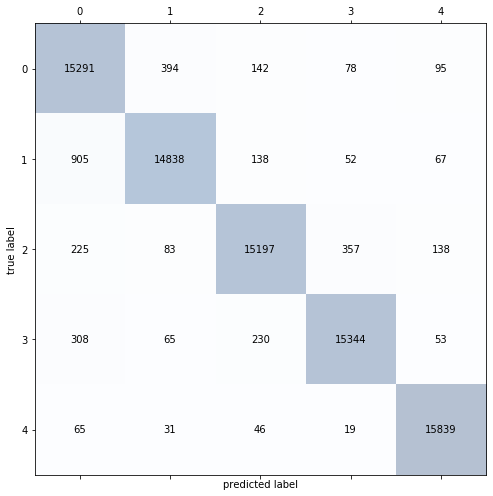

Valid set
========= Métricas do modelo ============

Loss is 0.014 Accuracy is 18870/20000 94.35%

              precision    recall  f1-score   support

           N      0.898     0.935     0.916      4000
           S      0.944     0.910     0.927      4000
           V      0.952     0.937     0.945      4000
           F      0.957     0.953     0.955      4000
           Q      0.969     0.982     0.975      4000

    accuracy                          0.944     20000
   macro avg      0.944     0.944     0.944     20000
weighted avg      0.944     0.944     0.944     20000


========= Confusion Matrix ============



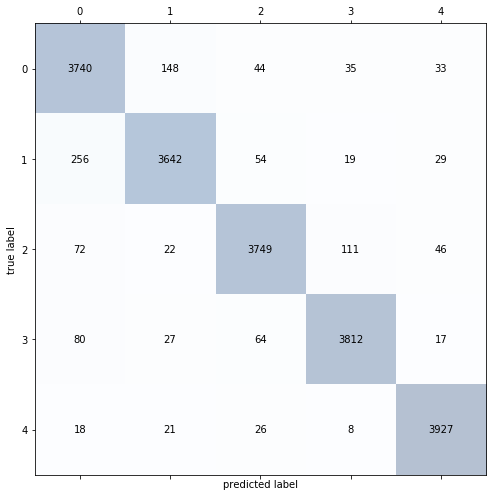

Test set
========= Métricas do modelo ============

Loss is 0.019 Accuracy is 20421/21892 93.28%

              precision    recall  f1-score   support

           N      0.992     0.934     0.962     18118
           S      0.401     0.813     0.537       556
           V      0.837     0.923     0.878      1448
           F      0.402     0.877     0.551       162
           Q      0.898     0.980     0.937      1608

    accuracy                          0.933     21892
   macro avg      0.706     0.905     0.773     21892
weighted avg      0.955     0.933     0.941     21892


========= Confusion Matrix ============



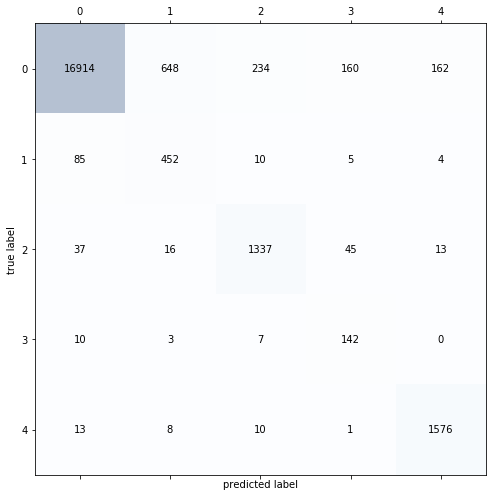

In [0]:
# t=5 alfa = 0.6
model = carregar_modeloRNN('bestLoss.model')
print('Train set')
metricasModelo(model, train_loader)
print('Valid set')
metricasModelo(model, valid_loader)
print('Test set')
metricasModelo(model, test_loader)

Train set
========= Métricas do modelo ============

Loss is 0.0054 Accuracy is 77003/80000 96.25%

              precision    recall  f1-score   support

           N      0.933     0.952     0.942     16000
           S      0.966     0.938     0.952     16000
           V      0.955     0.967     0.961     16000
           F      0.969     0.966     0.968     16000
           Q      0.990     0.990     0.990     16000

    accuracy                          0.963     80000
   macro avg      0.963     0.963     0.963     80000
weighted avg      0.963     0.963     0.963     80000


========= Confusion Matrix ============



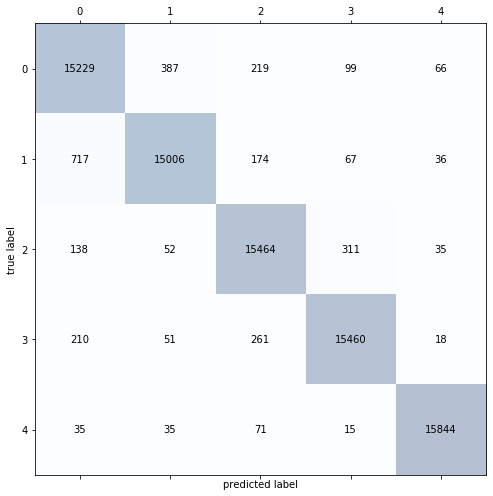

Valid set
========= Métricas do modelo ============

Loss is 0.0085 Accuracy is 18962/20000 94.81%

              precision    recall  f1-score   support

           N      0.907     0.928     0.917      4000
           S      0.951     0.916     0.933      4000
           V      0.944     0.954     0.949      4000
           F      0.957     0.961     0.959      4000
           Q      0.983     0.982     0.982      4000

    accuracy                          0.948     20000
   macro avg      0.948     0.948     0.948     20000
weighted avg      0.948     0.948     0.948     20000


========= Confusion Matrix ============



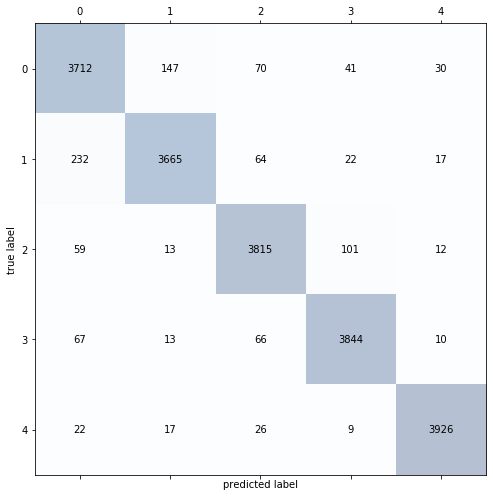

Test set
========= Métricas do modelo ============

Loss is 0.012 Accuracy is 20342/21892 92.92%

              precision    recall  f1-score   support

           N      0.992     0.928     0.959     18118
           S      0.398     0.817     0.535       556
           V      0.787     0.947     0.859      1448
           F      0.394     0.852     0.539       162
           Q      0.917     0.976     0.945      1608

    accuracy                          0.929     21892
   macro avg      0.698     0.904     0.768     21892
weighted avg      0.953     0.929     0.937     21892


========= Confusion Matrix ============



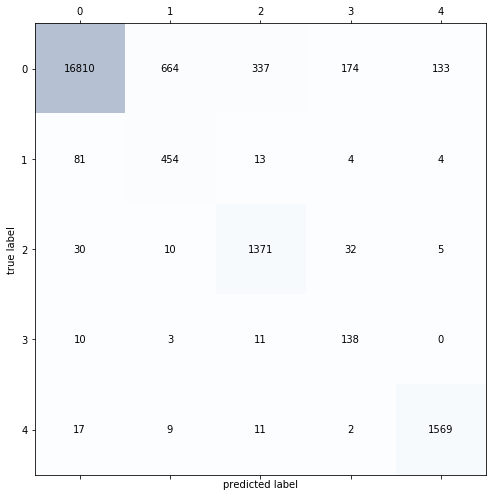

In [0]:
# t=4 alfa = 0.4
model = carregar_modeloRNN('bestLoss.model')
print('Train set')
metricasModelo(model, train_loader)
print('Valid set')
metricasModelo(model, valid_loader)
print('Test set')
metricasModelo(model, test_loader)

# Teste de hyperparameters


In [0]:
def treinamentoSoftHP(train_logits, valid_logits, train_loader, valid_loader, model, num_epochs, verbose, t, alpha):
  train_losses , train_accuracy = [],[]
  val_losses , val_accuracy = [],[]
  totalTime = 0
  optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # sets optimizer
  scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=20, verbose=verbose, min_lr=0.00005)
  best_loss, best_acc = fitSoftHP(valid_logits, verbose, optimizer, scheduler,model,valid_loader, t, alpha, phase='validation')
  
  if verbose:
    print("best_acc: " + str(best_acc))

  # initialize the early_stopping object
  early_stopping = EarlyStopping(patience=30, verbose=verbose)

  for epoch in range(1,num_epochs+1):
    if verbose:   
      print('epoch {}/{}'.format(epoch, num_epochs))
      print('=' * 10)
    epochStart = time.time()
    train_epoch_loss, train_epoch_accuracy = fitSoftHP(train_logits, verbose, optimizer, scheduler, model, train_loader, t, alpha, phase='training')
    val_epoch_loss , val_epoch_accuracy = fitSoftHP(valid_logits, verbose, optimizer, scheduler, model, valid_loader, t, alpha, phase='validation')
    epochEnd = time.time() 

    if verbose:   
      print('Duração:', (epochEnd - epochStart))

    if val_epoch_accuracy >= best_acc:
      best_acc = val_epoch_accuracy
      best_loss = val_epoch_loss
      salvar_modelo(model, 'bestAccuracy.model')
    
    train_losses.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
   
    early_stopping(val_epoch_loss, model)
    if early_stopping.early_stop:
      print("Early stopping in epoch", epoch)
      break
  
  return train_losses, train_accuracy, val_losses, val_accuracy 

def fitSoftHP(teacher_target, verbose, optimizer, scheduler, model, data_loader, t, alpha, phase='training'):
  if phase == 'training':
    model.train()
  if phase == 'validation':
    model.eval()
  running_loss = 0.0
  running_correct = 0
  ini = 0
  fim = 0
  for batch in data_loader:
    data , target = batch        
    fim = fim + len(target)
    if torch.cuda.is_available():
      data,target = data.cuda(),target.cuda()
    if phase == 'training':
      optimizer.zero_grad()
    output = model(data)
    soft_target = teacher_target[ini:fim]
    loss = loss_fn_kd(output, target, soft_target, t, alpha)
    running_loss += loss.item()
    output = output.data.cpu().numpy()   
    preds = np.argmax(output, axis=1)     
    running_correct += getCorrects(preds, target)
    if phase == 'training':
      loss.backward()
      optimizer.step()   
    ini = ini + len(target) 
  loss = running_loss/len(data_loader.sampler)
  accuracy = 100. * running_correct/len(data_loader.sampler)
  if phase == 'validation':
    scheduler.step(accuracy)
  if verbose:
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.sampler)}{accuracy:{6}.{4}}%')
  return loss,accuracy


def loss_fn_kd(outputs, labels, teacher_outputs, temperature, alpha): 
  """ 
  Compute the knowledge-distillation (KD) loss given outputs, labels. 
  "Hyperparameters": temperature and alpha 

  NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher 
  and student expects the input tensor to be log probabilities! See Issue #2 
  """ 
 
  T = temperature 
  KD_loss = nn.KLDivLoss()(F.softmax(outputs/T, dim=1), 
                          F.softmax(teacher_outputs/T, dim=1))*T*T*alpha + F.cross_entropy(outputs, labels) * (1. - alpha) 

  return KD_loss 

def getCorrects(preds, targets):  
  corretos = 0
  for i in range(0, len(targets)):
    if preds[i].item() == targets[i].item():
      corretos = corretos +1

  return corretos

t =  4 alpha =  0.4


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Train set
Loss is 0.0045 Accuracy is 77454/80000 96.82%

Valid set
Loss is 0.0086 Accuracy is 19031/20000 95.16%

Test set
========= Métricas do modelo ============

Loss is 0.014 Accuracy is 20223/21892 92.38%

              precision    recall  f1-score   support

           N      0.992     0.921     0.955     18118
           S      0.342     0.831     0.485       556
           V      0.834     0.932     0.881      1448
           F      0.373     0.883     0.525       162
           Q      0.916     0.980     0.947      1608

    accuracy                          0.924     21892
   macro avg      0.692     0.909     0.759     21892
weighted avg      0.955     0.924     0.935     21892


========= Confusion Matrix ============



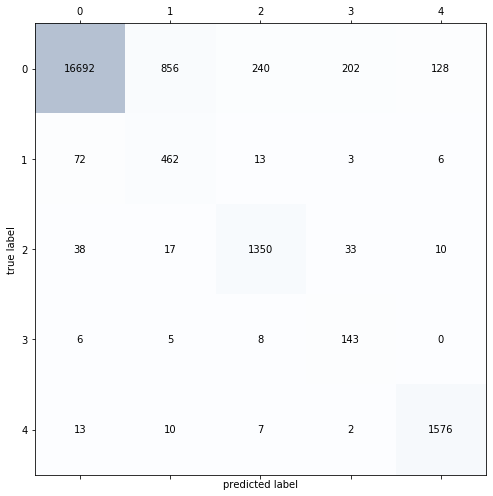

t =  4 alpha =  0.5
Train set
Loss is 0.0066 Accuracy is 76758/80000 95.95%

Valid set
Loss is 0.0097 Accuracy is 18953/20000 94.77%

Test set
========= Métricas do modelo ============

Loss is 0.015 Accuracy is 20184/21892  92.2%

              precision    recall  f1-score   support

           N      0.993     0.919     0.954     18118
           S      0.338     0.833     0.481       556
           V      0.805     0.935     0.865      1448
           F      0.359     0.914     0.516       162
           Q      0.948     0.978     0.963      1608

    accuracy                          0.922     21892
   macro avg      0.689     0.916     0.756     21892
weighted avg      0.956     0.922     0.934     21892


========= Confusion Matrix ============



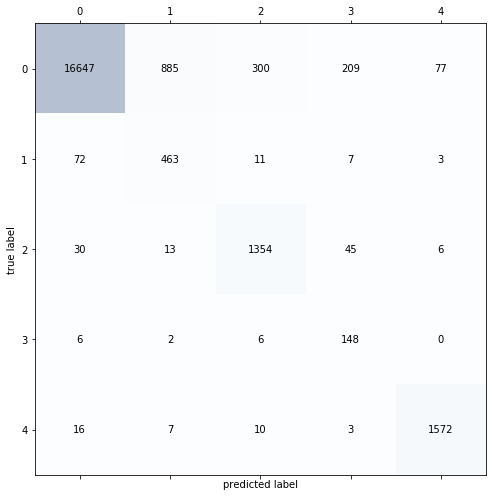

t =  4 alpha =  0.6
Train set
Loss is 0.0069 Accuracy is 76736/80000 95.92%

Valid set
Loss is 0.011 Accuracy is 18930/20000 94.65%

Test set
========= Métricas do modelo ============

Loss is 0.017 Accuracy is 20184/21892  92.2%

              precision    recall  f1-score   support

           N      0.993     0.919     0.954     18118
           S      0.351     0.831     0.493       556
           V      0.799     0.939     0.863      1448
           F      0.392     0.864     0.539       162
           Q      0.901     0.979     0.938      1608

    accuracy                          0.922     21892
   macro avg      0.687     0.907     0.758     21892
weighted avg      0.953     0.922     0.932     21892


========= Confusion Matrix ============



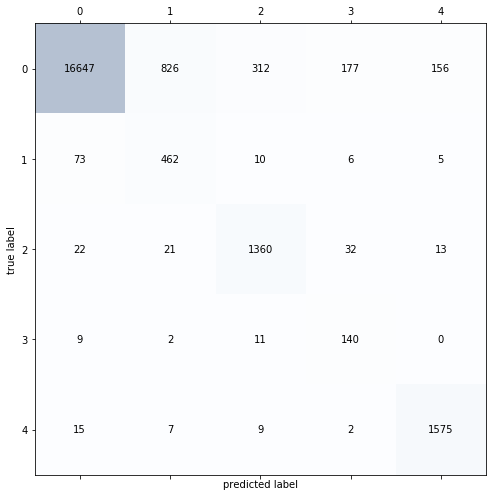

t =  4 alpha =  0.7
Train set
Loss is 0.007 Accuracy is 77242/80000 96.55%

Valid set
Loss is 0.011 Accuracy is 19052/20000 95.26%

Test set
========= Métricas do modelo ============

Loss is 0.017 Accuracy is 20441/21892 93.37%

              precision    recall  f1-score   support

           N      0.992     0.934     0.962     18118
           S      0.389     0.802     0.524       556
           V      0.827     0.940     0.880      1448
           F      0.407     0.852     0.551       162
           Q      0.924     0.979     0.951      1608

    accuracy                          0.934     21892
   macro avg      0.708     0.901     0.774     21892
weighted avg      0.956     0.934     0.942     21892


========= Confusion Matrix ============



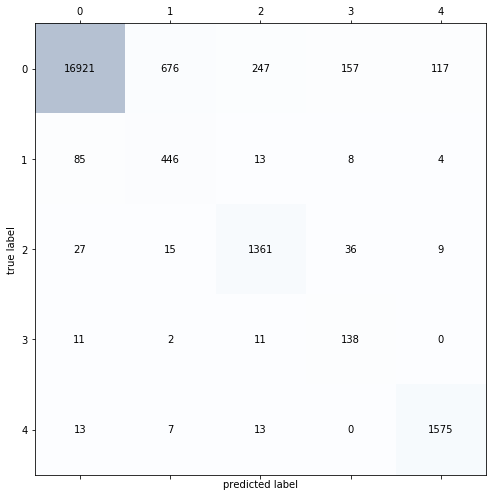

t =  5 alpha =  0.4
Train set
Loss is 0.0066 Accuracy is 76484/80000 95.61%

Valid set
Loss is  0.01 Accuracy is 18904/20000 94.52%

Test set
========= Métricas do modelo ============

Loss is 0.012 Accuracy is 20507/21892 93.67%

              precision    recall  f1-score   support

           N      0.991     0.938     0.964     18118
           S      0.438     0.797     0.565       556
           V      0.856     0.936     0.894      1448
           F      0.313     0.901     0.465       162
           Q      0.931     0.980     0.955      1608

    accuracy                          0.937     21892
   macro avg      0.706     0.910     0.769     21892
weighted avg      0.959     0.937     0.945     21892


========= Confusion Matrix ============



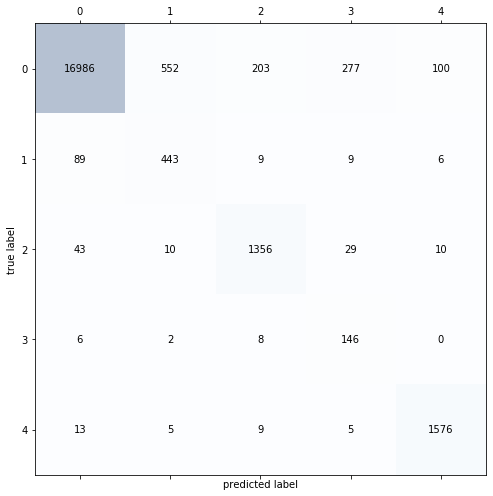

t =  5 alpha =  0.5
Train set
Loss is 0.0074 Accuracy is 76771/80000 95.96%

Valid set
Loss is 0.011 Accuracy is 18931/20000 94.66%

Test set
========= Métricas do modelo ============

Loss is 0.017 Accuracy is 20334/21892 92.88%

              precision    recall  f1-score   support

           N      0.991     0.929     0.959     18118
           S      0.379     0.799     0.514       556
           V      0.798     0.941     0.864      1448
           F      0.402     0.858     0.547       162
           Q      0.928     0.973     0.950      1608

    accuracy                          0.929     21892
   macro avg      0.699     0.900     0.767     21892
weighted avg      0.954     0.929     0.937     21892


========= Confusion Matrix ============



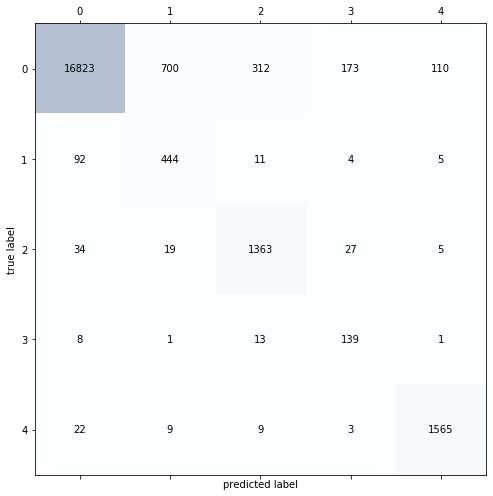

t =  5 alpha =  0.6
Train set
Loss is  0.01 Accuracy is 76350/80000 95.44%

Valid set
Loss is 0.015 Accuracy is 18898/20000 94.49%

Test set
========= Métricas do modelo ============

Loss is 0.018 Accuracy is 20524/21892 93.75%

              precision    recall  f1-score   support

           N      0.991     0.939     0.964     18118
           S      0.465     0.781     0.583       556
           V      0.809     0.941     0.870      1448
           F      0.388     0.883     0.539       162
           Q      0.905     0.981     0.941      1608

    accuracy                          0.938     21892
   macro avg      0.712     0.905     0.779     21892
weighted avg      0.955     0.938     0.943     21892


========= Confusion Matrix ============



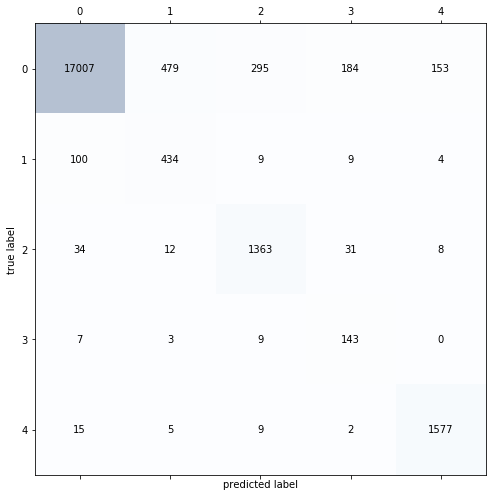

t =  5 alpha =  0.7
Train set
Loss is 0.011 Accuracy is 76445/80000 95.56%

Valid set
Loss is 0.016 Accuracy is 18855/20000 94.28%

Test set
========= Métricas do modelo ============

Loss is 0.021 Accuracy is 20428/21892 93.31%

              precision    recall  f1-score   support

           N      0.992     0.933     0.962     18118
           S      0.408     0.806     0.542       556
           V      0.808     0.941     0.870      1448
           F      0.376     0.895     0.529       162
           Q      0.929     0.980     0.954      1608

    accuracy                          0.933     21892
   macro avg      0.703     0.911     0.771     21892
weighted avg      0.956     0.933     0.941     21892


========= Confusion Matrix ============



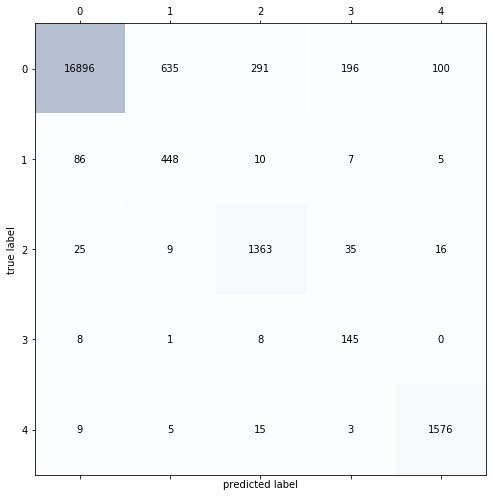

t =  6 alpha =  0.4
Train set
Loss is 0.0081 Accuracy is 76312/80000 95.39%

Valid set
Loss is 0.013 Accuracy is 18807/20000 94.03%

Test set
========= Métricas do modelo ============

Loss is 0.017 Accuracy is 20419/21892 93.27%

              precision    recall  f1-score   support

           N      0.991     0.933     0.961     18118
           S      0.443     0.795     0.569       556
           V      0.801     0.936     0.863      1448
           F      0.308     0.846     0.451       162
           Q      0.927     0.981     0.953      1608

    accuracy                          0.933     21892
   macro avg      0.694     0.898     0.760     21892
weighted avg      0.955     0.933     0.941     21892


========= Confusion Matrix ============



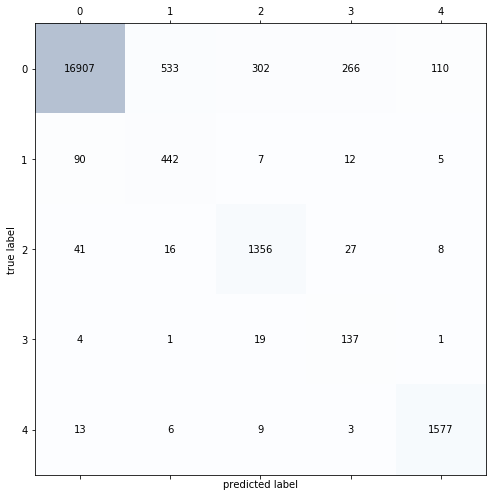

t =  6 alpha =  0.5
Train set
Loss is 0.0098 Accuracy is 76493/80000 95.62%

Valid set
Loss is 0.015 Accuracy is 18814/20000 94.07%

Test set
========= Métricas do modelo ============

Loss is 0.021 Accuracy is 20286/21892 92.66%

              precision    recall  f1-score   support

           N      0.991     0.927     0.958     18118
           S      0.422     0.804     0.553       556
           V      0.769     0.926     0.840      1448
           F      0.340     0.852     0.486       162
           Q      0.898     0.978     0.936      1608

    accuracy                          0.927     21892
   macro avg      0.684     0.897     0.755     21892
weighted avg      0.951     0.927     0.935     21892


========= Confusion Matrix ============



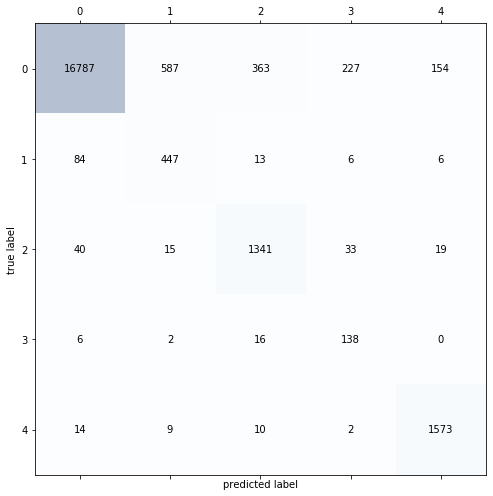

t =  6 alpha =  0.6
Train set
Loss is 0.011 Accuracy is 76521/80000 95.65%

Valid set
Loss is 0.017 Accuracy is 18866/20000 94.33%

Test set
========= Métricas do modelo ============

Loss is 0.024 Accuracy is 20078/21892 91.71%

              precision    recall  f1-score   support

           N      0.992     0.913     0.951     18118
           S      0.319     0.836     0.462       556
           V      0.841     0.934     0.885      1448
           F      0.365     0.864     0.513       162
           Q      0.893     0.977     0.933      1608

    accuracy                          0.917     21892
   macro avg      0.682     0.905     0.749     21892
weighted avg      0.953     0.917     0.930     21892


========= Confusion Matrix ============



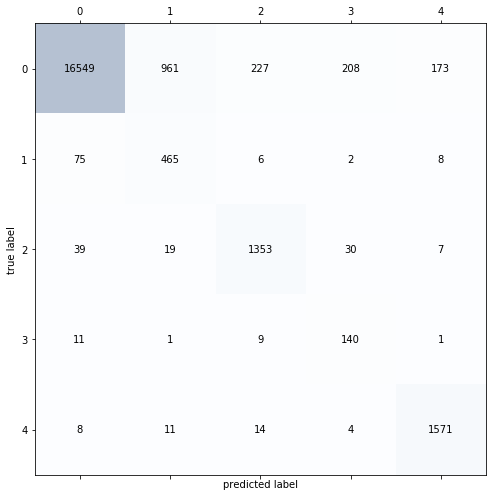

t =  6 alpha =  0.7
Train set
Loss is 0.014 Accuracy is 76459/80000 95.57%

Valid set
Loss is  0.02 Accuracy is 18903/20000 94.52%

Test set
========= Métricas do modelo ============

Loss is 0.026 Accuracy is 20318/21892 92.81%

              precision    recall  f1-score   support

           N      0.992     0.927     0.958     18118
           S      0.417     0.808     0.550       556
           V      0.776     0.934     0.848      1448
           F      0.336     0.914     0.491       162
           Q      0.926     0.978     0.951      1608

    accuracy                          0.928     21892
   macro avg      0.689     0.912     0.760     21892
weighted avg      0.953     0.928     0.937     21892


========= Confusion Matrix ============



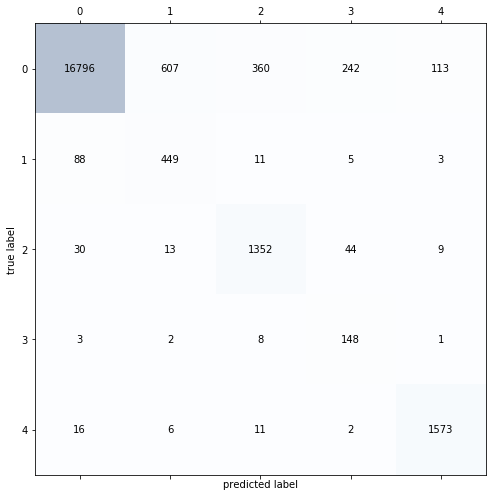

t =  7 alpha =  0.4
Train set
Loss is 0.0087 Accuracy is 76535/80000 95.67%

Valid set
Loss is 0.013 Accuracy is 18898/20000 94.49%

Test set
========= Métricas do modelo ============

Loss is 0.018 Accuracy is 20364/21892 93.02%

              precision    recall  f1-score   support

           N      0.993     0.929     0.959     18118
           S      0.406     0.818     0.543       556
           V      0.769     0.949     0.850      1448
           F      0.395     0.827     0.535       162
           Q      0.930     0.981     0.955      1608

    accuracy                          0.930     21892
   macro avg      0.699     0.901     0.768     21892
weighted avg      0.954     0.930     0.938     21892


========= Confusion Matrix ============



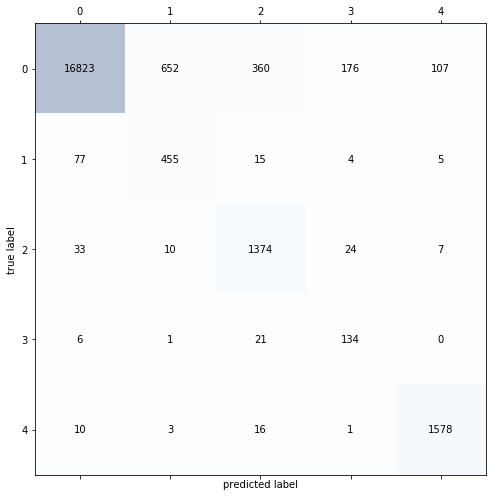

t =  7 alpha =  0.5
Train set
Loss is  0.01 Accuracy is 76850/80000 96.06%

Valid set
Loss is 0.017 Accuracy is 18892/20000 94.46%

Test set
========= Métricas do modelo ============

Loss is 0.027 Accuracy is 19995/21892 91.33%

              precision    recall  f1-score   support

           N      0.993     0.909     0.949     18118
           S      0.332     0.829     0.474       556
           V      0.790     0.930     0.854      1448
           F      0.325     0.914     0.479       162
           Q      0.895     0.979     0.936      1608

    accuracy                          0.913     21892
   macro avg      0.667     0.912     0.738     21892
weighted avg      0.951     0.913     0.926     21892


========= Confusion Matrix ============



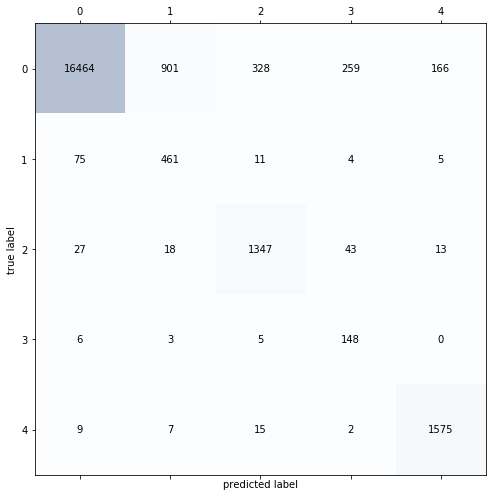

t =  7 alpha =  0.6
Train set
Loss is 0.012 Accuracy is 76664/80000 95.83%

Valid set
Loss is 0.019 Accuracy is 18898/20000 94.49%

Test set
========= Métricas do modelo ============

Loss is 0.025 Accuracy is 20413/21892 93.24%

              precision    recall  f1-score   support

           N      0.991     0.934     0.961     18118
           S      0.391     0.802     0.526       556
           V      0.823     0.932     0.874      1448
           F      0.384     0.852     0.530       162
           Q      0.930     0.973     0.951      1608

    accuracy                          0.932     21892
   macro avg      0.704     0.899     0.768     21892
weighted avg      0.956     0.932     0.941     21892


========= Confusion Matrix ============



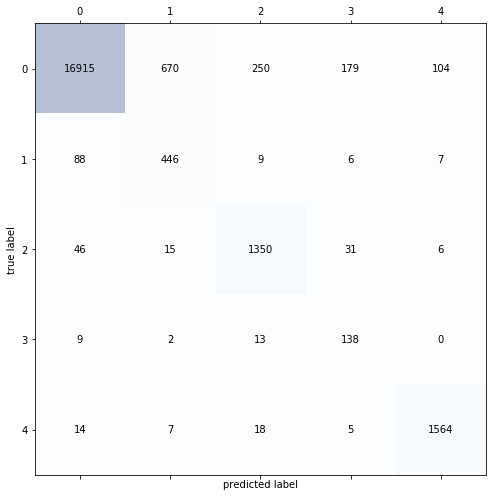

t =  7 alpha =  0.7
Train set
Loss is 0.015 Accuracy is 76659/80000 95.82%

Valid set
Loss is 0.022 Accuracy is 18897/20000 94.48%

Test set
========= Métricas do modelo ============

Loss is 0.028 Accuracy is 20480/21892 93.55%

              precision    recall  f1-score   support

           N      0.991     0.938     0.964     18118
           S      0.425     0.790     0.553       556
           V      0.789     0.930     0.854      1448
           F      0.387     0.827     0.528       162
           Q      0.947     0.972     0.959      1608

    accuracy                          0.936     21892
   macro avg      0.708     0.891     0.771     21892
weighted avg      0.955     0.936     0.942     21892


========= Confusion Matrix ============



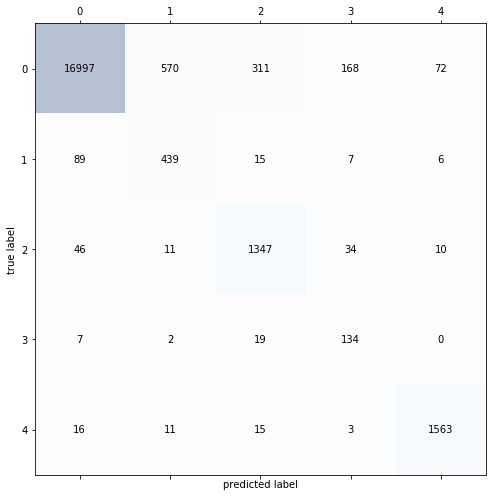

In [0]:
list_t = [4, 5, 6, 7]
list_alpha = [0.4, 0.5, 0.6, 0.7]

for t in list_t:
  for alpha in list_alpha:
    print('====================================')
    print('t = ', t, 'alpha = ', alpha)

    #Cria o modelo 
    model = ModeloRNN(187, 30, 32)
    if(torch.cuda.is_available):
      model = model.cuda()

    #treinamento  
    train_losses, train_accuracy, val_losses, val_accuracy = treinamentoSoftHP( train_logits, valid_logits, train_loader, valid_loader, model, 75, False, t, alpha)
    
    #métricas
    model = carregar_modeloRNN('bestLoss.model')
    print('Train set')
    tot_predictions, labels = testeDoModelo(model, train_loader)
    print('Valid set')
    tot_predictions, labels = testeDoModelo(model, valid_loader)
    print('Test set')
    metricasModelo(model, test_loader)

